# Introduction
In this notebook, I will try to improve the performance of 2 baseline classification models (Logistic Regression and Cat Boost) by adding Dimensionality Reduction methods (PCA and KernelPCA) and clustering methods (KMeans and Agglomerative Clustering).

If the addition of these methods proves itself useful, I will later incorporate them in my notebook [Titanic Spaceship](https://www.kaggle.com/code/semenvasilev/classification-coursera).<br>
It is part of my studying of Machine learning through the [IBM Machine Learning Professional Certificate](https://www.coursera.org/professional-certificates/ibm-machine-learning).

## Data description
The data was provided by Kaggle as a Spaceship Titanic Competition. There are two data sets: train and test. Train data set have information about success\unsuccess passengers transportation. 

* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard. Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.

* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict

## Project methodology
1) Fillng missing values
2) Create new fatures
3) Check base model perfomance (Logistick Regrestion and CatBoost)
4) Add dimensionality Reduction methods (PCA and KernelPCA) and clustering methods (KMeans and Agglomerative Clustering)
5) Do Hard and Soft Voting

# Code
## Libraries

In [1]:
# Core
import numpy as np 
import pandas as pd 
import random

#Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearnю Support libs
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix



# Models
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Clustering
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import FunctionTransformer

## Data

In [2]:
df_train = pd.read_csv('../input/spaceship-titanic/train.csv')
df_test = pd.read_csv('../input/spaceship-titanic/test.csv')

In [3]:
print('Train set shape:', df_train.shape)
print('-'*60)
df_train.head()

Train set shape: (8693, 14)
------------------------------------------------------------


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
print('Test set shape:', df_test.shape)
print('-'*60)
df_test.head()

Test set shape: (4277, 13)
------------------------------------------------------------


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


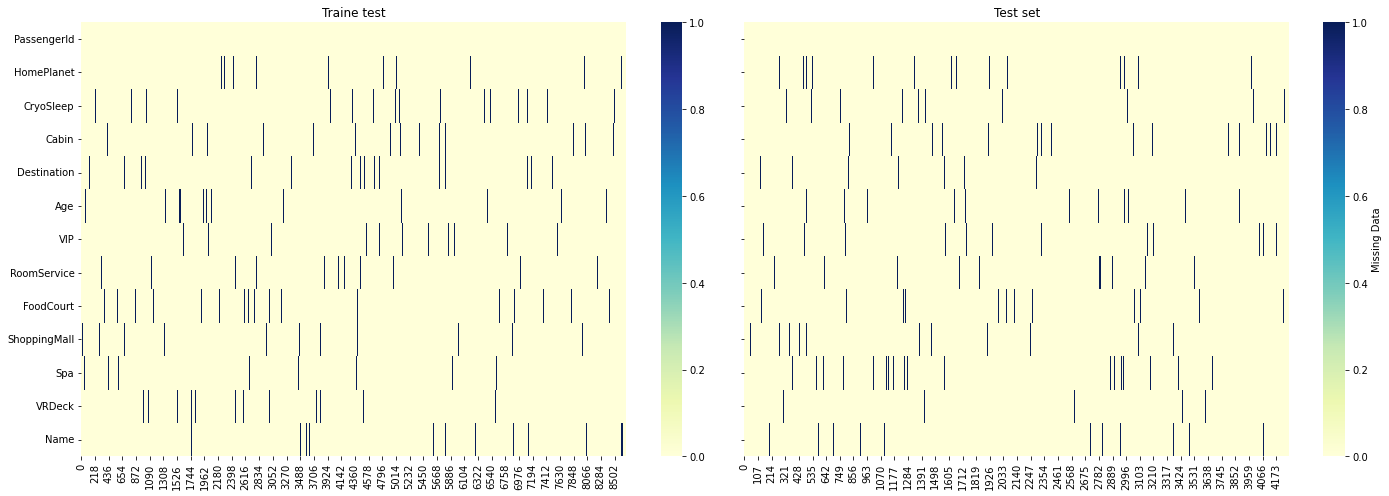

In [7]:
#Viz missing data
fig, ax = plt.subplots(1, 2, sharex = False, sharey = True, figsize = (20, 7))
f1=sns.heatmap(df_train.isna().transpose(),
            cmap = "YlGnBu",
            ax = ax[0]) 
f1.set_title('Traine test')
plt.title('Train set')
f2=sns.heatmap(df_test.isna().transpose(),
            cmap = "YlGnBu",
            cbar_kws = {'label': 'Missing Data'},
            ax = ax[1])
f2.set_title('Test set')
fig.tight_layout()

In [8]:
# Calculate missing data 
percent_missing_train = df_train.isnull().sum() * 100 / len(df_train)
print (f'Missing Values.\n{"-"*60} \n1. Train set:')
for column in df_train.columns:
    print (f'{column} : {df_train[column].isna().sum()} ({percent_missing_train[column].round(2)}%)')
print('-'*60)
percent_missing_test = df_test.isnull().sum() * 100 / len(df_test)
print ('2. Test set:')
for column in df_test.columns:
    print (f'{column} : {df_test[column].isna().sum()} ({percent_missing_test[column].round(2)}%)')

Missing Values.
------------------------------------------------------------ 
1. Train set:
PassengerId : 0 (0.0%)
HomePlanet : 201 (2.31%)
CryoSleep : 217 (2.5%)
Cabin : 199 (2.29%)
Destination : 182 (2.09%)
Age : 179 (2.06%)
VIP : 203 (2.34%)
RoomService : 181 (2.08%)
FoodCourt : 183 (2.11%)
ShoppingMall : 208 (2.39%)
Spa : 183 (2.11%)
VRDeck : 188 (2.16%)
Name : 200 (2.3%)
Transported : 0 (0.0%)
------------------------------------------------------------
2. Test set:
PassengerId : 0 (0.0%)
HomePlanet : 87 (2.03%)
CryoSleep : 93 (2.17%)
Cabin : 100 (2.34%)
Destination : 92 (2.15%)
Age : 91 (2.13%)
VIP : 93 (2.17%)
RoomService : 82 (1.92%)
FoodCourt : 106 (2.48%)
ShoppingMall : 98 (2.29%)
Spa : 101 (2.36%)
VRDeck : 80 (1.87%)
Name : 94 (2.2%)


In [9]:
df_train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

### EDA on both Sets together


e can use merged data set as it is information from one source and for one item (spaceship).

In [10]:
# Save information about Transported and Index
df_train_trans = df_train[['Transported']]

# Merge data sets in one
df_full=df_train.merge(df_test, how = 'outer')

In [11]:
# Function to create Train data set Flag column
def TransportedF (row):
    if row['Transported'] != row['Transported']: # NaN
        return 0
    else:
        return 1 # True\False

# Applying function   
df_full['TransportedF'] = df_full.apply(lambda row: TransportedF(row), axis=1)

# Drop Transported column
df_full = df_full.drop('Transported', axis=1)

In [12]:
#Create new columns
df_full[['Deck','Num','Side']] = df_full['Cabin'].str.split('/',expand=True)
df_full = df_full.drop('Cabin', axis=1)
df_full[['Name','Surname']] = df_full['Name'].str.split(' ', expand=True)
df_full[['PassengerId', 'NGroup']] = df_full['PassengerId'].str.split('_', expand =True)
df_full['AllServices'] = df_full['RoomService'] + df_full['FoodCourt'] + df_full['ShoppingMall'] + df_full['Spa'] + df_full['VRDeck']

In [13]:
# Function to create All Services (the sum of all expenditures for each passenger) Flag column
def empty_services (row):
    if row['AllServices'] != row['AllServices']: # at least one of service is no information
        return 'NaN'
    elif row['AllServices'] == 0.0: # no services
        return 0
    else:
        return 1 # is services
# Applying function   
df_full['AllServicesF'] = df_full.apply(lambda row: empty_services(row), axis=1)

In [14]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 12969
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Destination   12696 non-null  object 
 4   Age           12700 non-null  float64
 5   VIP           12674 non-null  object 
 6   RoomService   12707 non-null  float64
 7   FoodCourt     12681 non-null  float64
 8   ShoppingMall  12664 non-null  float64
 9   Spa           12686 non-null  float64
 10  VRDeck        12702 non-null  float64
 11  Name          12676 non-null  object 
 12  TransportedF  12970 non-null  int64  
 13  Deck          12671 non-null  object 
 14  Num           12671 non-null  object 
 15  Side          12671 non-null  object 
 16  Surname       12676 non-null  object 
 17  NGroup        12970 non-null  object 
 18  AllServices   11607 non-nu

In [15]:
df_full

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,TransportedF,Deck,Num,Side,Surname,NGroup,AllServices,AllServicesF
0,0001,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham,1,B,0,P,Ofracculy,01,0.0,0
1,0002,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna,1,F,0,S,Vines,01,736.0,1
2,0003,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark,1,A,0,S,Susent,01,10383.0,1
3,0003,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam,1,A,0,S,Susent,02,5176.0,1
4,0004,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy,1,F,1,S,Santantines,01,1091.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron,0,G,1496,S,Peter,02,0.0,0
12966,9269,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty,0,NaN,NaN,NaN,Scheron,01,1018.0,1
12967,9271,Mars,True,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin,0,D,296,P,Pore,01,0.0,0
12968,9273,Europa,False,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan,0,D,297,P,Conale,01,3203.0,1


### Filling Missing Values

In [16]:
# Look information. CryoSleep == True. If True then all spenduture we can fill 0. 
df_sleep = df_full.loc[df_full['CryoSleep'] == True]

# Check there are not Allservicesf 1 and cryosleep == true
df_sleep.groupby(['AllServicesF', 'CryoSleep' ])['CryoSleep'].size().unstack()

CryoSleep,True
AllServicesF,
0,4068
NaN,513


In [17]:
# Replace 
columns_services = ('RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck')
for col in columns_services:
    df_full.loc[(df_full[col].isna()) & (df_full['CryoSleep'] == True), col] = 0


# Recalculate with new data
df_full['AllServices'] = df_full['RoomService'] + df_full['FoodCourt'] + df_full['ShoppingMall'] + df_full['Spa'] + df_full['VRDeck']
df_full['AllServicesF'] = df_full.apply(lambda row: empty_services(row), axis=1)

Next step. If there is any spending cryosleep will be false

In [18]:
df_full.loc[(df_full['AllServicesF'] == 1) & (df_full['CryoSleep'].isna()), 'CryoSleep'] = False

In [19]:
percent_missing_full = df_full.isnull().sum() * 100 / len(df_full)
print (f'Missing Values.\n{"-"*60}')
column = 'CryoSleep'
print (f'{column} : {df_full[column].isna().sum()} ({percent_missing_full[column].round(2)}%)')

Missing Values.
------------------------------------------------------------
CryoSleep : 153 (1.18%)


In [20]:
# Update age group feature
df_full.loc[df_full['Age']<=12,'Age_group']='Age_0-12'
df_full.loc[(df_full['Age']>12) & (df_full['Age']<18),'Age_group']='Age_13-17'
df_full.loc[(df_full['Age']>=18) & (df_full['Age']<=25),'Age_group']='Age_18-25'
df_full.loc[(df_full['Age']>25) & (df_full['Age']<=30),'Age_group']='Age_26-30'
df_full.loc[(df_full['Age']>30) & (df_full['Age']<=50),'Age_group']='Age_31-50'
df_full.loc[df_full['Age']>50,'Age_group']='Age_51+'

Text(0.5, 0, 'Age (years)')

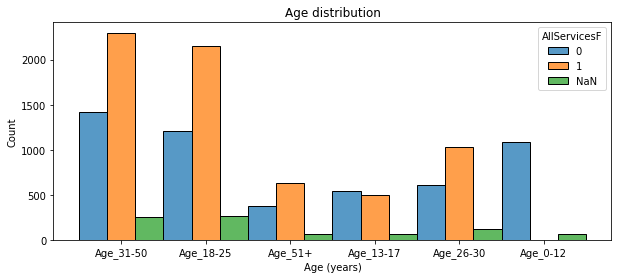

In [21]:
# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=df_full, x='Age_group', hue='AllServicesF', multiple="dodge")

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

In [22]:
# check there are not allservicesf 1 and cryosleep == true
df_full.groupby(['Age_group', 'CryoSleep', 'AllServicesF' ])['AllServicesF'].size().unstack()

AllServicesF              0       1    NaN
Age_group CryoSleep                       
Age_0-12  False       524.0     NaN   58.0
          True        545.0     NaN    NaN
Age_13-17 False         6.0   501.0   62.0
          True        522.0     NaN    NaN
Age_18-25 False        41.0  2152.0  262.0
          True       1134.0     NaN    NaN
Age_26-30 False        21.0  1034.0  121.0
          True        578.0     NaN    NaN
Age_31-50 False        47.0  2299.0  241.0
          True       1341.0     NaN    NaN
Age_51+   False        15.0   631.0   67.0
          True        347.0     NaN    NaN

There are no bills up to 12 years old. Any expenditure from 13 years.

In [23]:
df_full['AllServicesF'].value_counts()

1      6749
0      5371
NaN     850
Name: AllServicesF, dtype: int64

In [24]:
# replace 
columns_services = ('RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck')
for col in columns_services:
    df_full.loc[(df_full[col].isna()) & (df_full['Age'] <= 12), col] = 0


# recalculate
df_full['AllServices'] = df_full['RoomService'] + df_full['FoodCourt'] + df_full['ShoppingMall'] + df_full['Spa'] + df_full['VRDeck']
df_full['AllServicesF'] = df_full.apply(lambda row: empty_services(row), axis=1)

In [25]:
df_full['AllServicesF'].value_counts()

1      6749
0      5436
NaN     785
Name: AllServicesF, dtype: int64

In [26]:
# Check there are not AllservicesF 1 and CryoSleep == True
df_full.groupby(['Age_group', 'CryoSleep', 'AllServicesF' ])['AllServicesF'].size().unstack()

AllServicesF              0       1    NaN
Age_group CryoSleep                       
Age_0-12  False       582.0     NaN    NaN
          True        545.0     NaN    NaN
Age_13-17 False         6.0   501.0   62.0
          True        522.0     NaN    NaN
Age_18-25 False        41.0  2152.0  262.0
          True       1134.0     NaN    NaN
Age_26-30 False        21.0  1034.0  121.0
          True        578.0     NaN    NaN
Age_31-50 False        47.0  2299.0  241.0
          True       1341.0     NaN    NaN
Age_51+   False        15.0   631.0   67.0
          True        347.0     NaN    NaN

I suppose the best option is to fill NaN by the mean value. It is reasonable in the case of all values except NaN being equal to zero. In other cases, it is just a suppose.
In 27 cases, we have 2 NaNs in one row. It is a tiny amount, and I did not do anything special with them.

In [27]:
# List of interesting columns
columns_services = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
# Create temp columns
df_full['sum_services'] = df_full[columns_services].sum(axis = 1)  # Sum of all services (NaN considered as a 0)
df_full['sum_na'] = df_full[columns_services].apply(lambda row: sum(row.isna()), axis=1) # NaNs number in services
df_full['MeanServices']=df_full['sum_services']/(5 - df_full['sum_na']) # Mean value. It will be not temp column

In [28]:
# Inpute NaN in Services columns by Mean value
for col in columns_services:
    df_full.loc[df_full[col].isna(), col] = df_full['MeanServices']

# Recalculate
df_full['AllServices'] = df_full['RoomService'] + df_full['FoodCourt'] + df_full['ShoppingMall'] + df_full['Spa'] + df_full['VRDeck']
df_full['AllServicesF'] = df_full.apply(lambda row: empty_services(row), axis=1)

#Drop temp columns
df_full=df_full.drop(['sum_services', 'sum_na'], axis=1)

If somebody spent money, they are not in CryoSleep

In [29]:
df_full.loc[(df_full['AllServicesF'] == 1) & (df_full['CryoSleep'] != df_full['CryoSleep']), 'CryoSleep'] = False

At this stage, I have 136 (1.05%) missing values in the column "CryoSleep".
I checked Groups and Cabins, Destination and Home Planet, and Age Groups. There are in one Cabin, or one Group can be a different status of CrySleep. I did not find additional insights. Based on this, I fill in missing values randomly according to the percentage in the total population. 

In [30]:
def replace_na(x):
    """Replace NaN values with values randomly selected from the Series."""
    vc = x.value_counts()
    r = random.choices(vc.keys(), weights=vc.values, k=x.isnull().sum())
    x[x.isnull()] = r
    return x

# reference to the function https://stackoverflow.com/questions/65096532/fill-nan-values-of-dataframe-with-random-values-from-the-column-depending-on-fr?newreg=b7b5cf5033f745caa6bbdbfa9d20feb1

In [31]:
random.seed(43)
df_full['CryoSleep'] = replace_na(df_full['CryoSleep'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


VIP filling. There is no VIP status if any of those:
1) Age < 18 
2) Home Planet Earth 
3) Deck G and T 
4) NGroup 6, 7, 8

Other columns have mixed dependances


In [32]:
df_VIP = df_full.loc[(df_full['VIP'] == True)]

<AxesSubplot:xlabel='Age_group', ylabel='Count'>

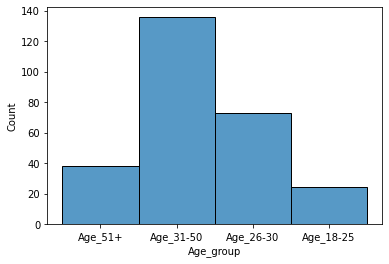

In [33]:
sns.histplot(data=df_VIP, x='Age_group')

<AxesSubplot:xlabel='HomePlanet', ylabel='Count'>

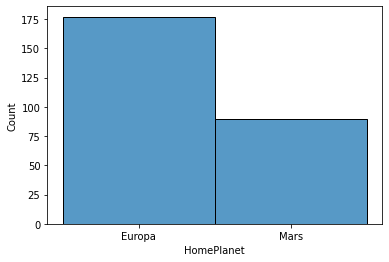

In [34]:
sns.histplot(data=df_VIP, x='HomePlanet')

<AxesSubplot:xlabel='Deck', ylabel='Count'>

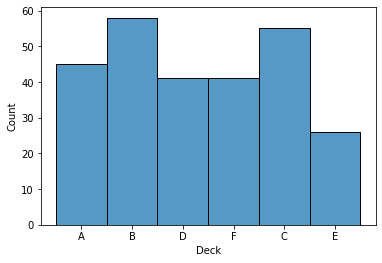

In [35]:
sns.histplot(data=df_VIP, x='Deck')

<AxesSubplot:xlabel='NGroup', ylabel='Count'>

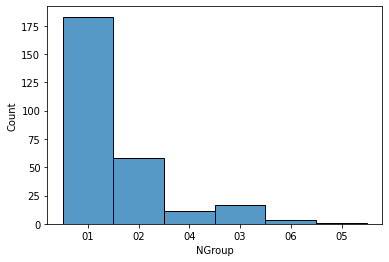

In [36]:
sns.histplot(data=df_VIP, x='NGroup')

In [37]:
# Fillings by insights
df_full['NGroup'] = df_full['NGroup'].astype(int)
df_full.loc[(df_full['VIP'] != df_full['VIP']) & 
            ((df_full['NGroup'] > 5) | (df_full['Deck'] == 'G') | 
            (df_full['Deck'] == 'T') | (df_full['Age'] < 18) | (df_full['HomePlanet'] == 'Earth')), 'VIP'] = False

In [38]:
# Fillings by random based on total population becouse I have no other rulls
df_full['VIP'] = replace_na(df_full['VIP'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Age has correlation with all fetures. In this case I filled missing values by mean value

In [39]:
df_full.loc[(df_full['Age'] != df_full['Age']), 'Age'] = df_full['Age'].mean().round(1)

In [40]:
# Update age group feature
df_full.loc[df_full['Age']<=12,'Age_group']='Age_0-12'
df_full.loc[(df_full['Age']>12) & (df_full['Age']<18),'Age_group']='Age_13-17'
df_full.loc[(df_full['Age']>=18) & (df_full['Age']<=25),'Age_group']='Age_18-25'
df_full.loc[(df_full['Age']>25) & (df_full['Age']<=30),'Age_group']='Age_26-30'
df_full.loc[(df_full['Age']>30) & (df_full['Age']<=50),'Age_group']='Age_31-50'
df_full.loc[df_full['Age']>50,'Age_group']='Age_51+'

Planets (Home and PassengerId)

I got idea how to do this code here https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide

In [41]:
HP_gb=df_full.groupby(['PassengerId','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
for col in HP_gb.columns:
    HP_gb[col] = HP_gb[col].apply(lambda x: x if x<=1 else 1)
HP_gb['x']=HP_gb['Earth']+HP_gb['Europa']+HP_gb['Mars']
HP_gb['x'].nunique()

1

In one PassengerId can be only one Home Planet

In [42]:
# Passengers with missing HomePlanet and in a group with known HomePlanet
HP_index=df_full[df_full['HomePlanet'].isna()][(df_full[df_full['HomePlanet'].isna()]['PassengerId']).isin(HP_gb.index)].index

# Fill corresponding missing values
df_full.loc[HP_index,'HomePlanet']=df_full.iloc[HP_index,:]['PassengerId'].map(lambda x: HP_gb.idxmax(axis=1)[x])

Planets (Home and Deck)

In [43]:
# Joint distribution of Deck and HomePlanet
DHP_gb=df_full.groupby(['Deck','HomePlanet'])['HomePlanet'].size().unstack()
DHP_gb

HomePlanet,Earth,Europa,Mars
Deck,,,
A,NaN,352.0,NaN
B,NaN,1137.0,NaN
C,NaN,1096.0,NaN
D,NaN,301.0,410.0
E,589.0,199.0,515.0
F,2437.0,NaN,1742.0
G,3731.0,NaN,NaN
T,NaN,10.0,NaN


Deck A - only Europa <br>
Deck B - only Europa <br>
Deck C - only Europa <br>
Deck D - Europa and Mars <br>
Deck E - Europa, Mars and Earth<br>
Deck F - Earth and Mars<br>
Deck G - only Earth<br>
Deck T - only Europa<br>


In [44]:
# Replace Home planet based Deck
df_full.loc[(df_full['HomePlanet'] != df_full['HomePlanet']) & 
            ((df_full['Deck'] == 'A') | (df_full['Deck'] == 'T') | 
            (df_full['Deck'] == 'B') | (df_full['Deck'] == 'C')), 'HomePlanet'] = 'Europa'
df_full.loc[(df_full['HomePlanet'] != df_full['HomePlanet']) & (df_full['Deck'] == 'G') , 'HomePlanet'] = 'Earth'

Home Planet and Surname

In [45]:
SHP_gb=df_full.groupby(['Surname','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
for col in SHP_gb.columns:
    SHP_gb[col] = SHP_gb[col].apply(lambda x: x if x<=1 else 1)
SHP_gb['x']=SHP_gb['Earth']+SHP_gb['Europa']+SHP_gb['Mars']
SHP_gb['x'].nunique()

1

One Surname from one Home Planet

In [46]:
# Passengers with missing HomePlanet and in a group with known HomePlanet
SHP_index=df_full[df_full['HomePlanet'].isna()][(df_full[df_full['HomePlanet'].isna()]['Surname']).isin(SHP_gb.index)].index

# Fill corresponding missing values
df_full.loc[SHP_index,'HomePlanet']=df_full.iloc[SHP_index,:]['Surname'].map(lambda x: SHP_gb.idxmax(axis=1)[x])

Based on Data, we know HomePlanets spread evenly on Deck.


In [47]:
df1=df_full.loc[(df_full['HomePlanet'] != df_full['HomePlanet'])][['Destination', 'Deck']]
df1

,Destination,Deck
2274,TRAPPIST-1e,D
2631,TRAPPIST-1e,F
3091,TRAPPIST-1e,F
4548,TRAPPIST-1e,F
5762,TRAPPIST-1e,F
8969,TRAPPIST-1e,E
10583,TRAPPIST-1e,D
11913,TRAPPIST-1e,E
12551,TRAPPIST-1e,F
12725,TRAPPIST-1e,D


The last 10 missing Home planet have identical destination TRAPPIST-1e. Decks: D, E, F.
It may be any Home Planet.

In [48]:
# Joint distribution of HomePlanet and Destination
HPD_gb=df_full.groupby(['HomePlanet','Destination'])['Destination'].size().unstack()
HPD_gb

Destination,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
HomePlanet,,,
Earth,1000,1085,4778
Europa,1341,29,1769
Mars,300,70,2314


In [49]:
# slice for chossing nedded data
df2=df_full.loc[((df_full['Deck'] == 'D') | (df_full['Deck'] == 'E') | (df_full['Deck'] == 'F')) & (df_full['Destination'] == 'TRAPPIST-1e') ]['HomePlanet']

# Replace by random function with weights
df_full['homeplanet1'] = replace_na(df2) # do it in temp column
df_full['HomePlanet'] = df_full['HomePlanet'].fillna(df_full['homeplanet1'])# filled na from new column. I did id becouse sliesed df before
df_full = df_full.drop('homeplanet1', axis=1) # drop temp column

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


Destinations <br> I did not find any meaningful insight. Missing values were filled by random with weight consideration.

In [50]:
# Replace by random function
df_full['Destination'] = replace_na(df_full['Destination']) 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Group and Side

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


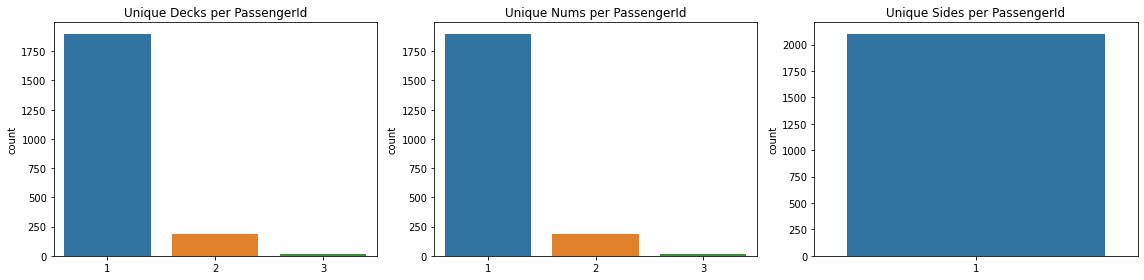

In [51]:
# Joint distribution of PassengerId and Cabin features
GD_gb=df_full[df_full['NGroup']>1].groupby(['PassengerId','Deck'])['Deck'].size().unstack().fillna(0)
GN_gb=df_full[df_full['NGroup']>1].groupby(['PassengerId','Num'])['Num'].size().unstack().fillna(0)
GS_gb=df_full[df_full['NGroup']>1].groupby(['PassengerId','Side'])['Side'].size().unstack().fillna(0)

# Countplots
fig=plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.countplot((GD_gb>0).sum(axis=1))
plt.title('Unique Decks per PassengerId')

plt.subplot(1,3,2)
sns.countplot((GN_gb>0).sum(axis=1))
plt.title('Unique Nums per PassengerId')

plt.subplot(1,3,3)
sns.countplot((GS_gb>0).sum(axis=1))
plt.title('Unique Sides per PassengerId')
fig.tight_layout()

All groups members are at one side

In [52]:
# That should be done for work with all group size. If use >1 group size 2 will not be filled. I dont know why))
GS_gb=df_full[df_full['NGroup']>0].groupby(['PassengerId','Side'])['Side'].size().unstack().fillna(0)

GS_index=df_full[df_full['Side'].isna()][df_full[df_full['Side'].isna()]['PassengerId'].isin(GS_gb.index)].index
df_full.loc[GS_index,'Side']=df_full.iloc[GS_index,:]['PassengerId'].map(lambda x: GS_gb.idxmax(axis=1)[x])

All last 162 NaN in Side also have NaN in Deck and Num

In [53]:
df_full['HomePlanet'][(df_full['Side'] != df_full['Side'])].value_counts()

Earth     101
Mars       32
Europa     29
Name: HomePlanet, dtype: int64

Missing values for Deck were filled randomlly with weights based on Home Planet

In [54]:
# slise fror chossing nedded data
df3=df_full.loc[(df_full['HomePlanet'] == 'Europa')]['Deck']
df4=df_full.loc[(df_full['HomePlanet'] == 'Mars')]['Deck']
df5=df_full.loc[(df_full['HomePlanet'] == 'Earth')]['Deck']

# Replace by random function
df_full['deck1'] = replace_na(df3) # do it in temp column
df_full['Deck'] = df_full['Deck'].fillna(df_full['deck1'][(df_full['HomePlanet'] == 'Europa')])# filled na from new column. I did id becouse sliesed df before
df_full['deck2'] = replace_na(df4) # do it in temp column
df_full['Deck'] = df_full['Deck'].fillna(df_full['deck2'][(df_full['HomePlanet'] == 'Mars')])# filled na from new column. I did id becouse sliesed df before
df_full['deck3'] = replace_na(df5) # do it in temp column
df_full['Deck'] = df_full['Deck'].fillna(df_full['deck3'][(df_full['HomePlanet'] == 'Earth')])# filled na from new column. I did id becouse sliesed df before

# drop temp column
df_full = df_full.drop(columns = {'deck1','deck2', 'deck3'})


/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


Last 162 Cabine side I filled randomlly with weights based on othr cabin Side values

In [55]:
df_full['Side'] = replace_na(df_full['Side']) # do it in temp column

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Num based on PassengerId and Num 

In [56]:
df_full['Num'] = df_full['Num'].astype(float)
df_full['PassengerId'] = df_full['PassengerId'].astype(float)

I got idea how to do this part here https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide

Text(0.5, 1.0, 'Num vs PassengerId coloured by Deck')

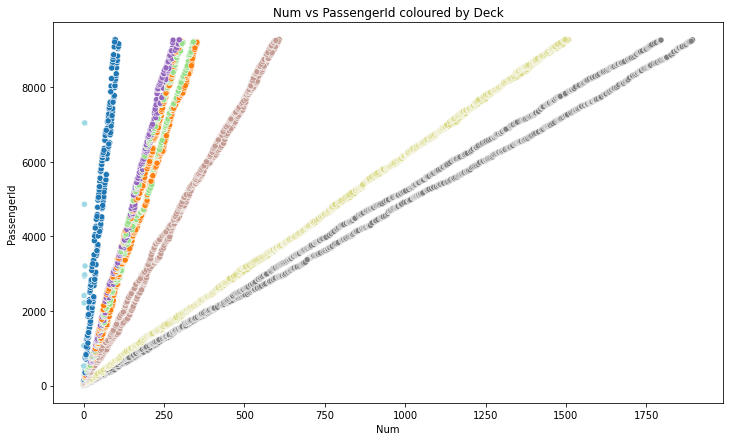

In [57]:
# Scatterplot
plt.figure(figsize=(12,7))
sns.scatterplot(x=df_full['Num'], y=df_full['PassengerId'], c=LabelEncoder().fit_transform(df_full.loc[~df_full['Num'].isna(),'Deck']), cmap='tab20')
plt.title('Num vs PassengerId coloured by Deck')

There is a linear pattern of Num distribution based on PassengerID  on Deck. 

In [58]:
# Extrapolate linear relationship on a deck by deck basis

for side in ['P', 'S']: # I add this loop for bigger accuracy of prediction 
    for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']: # There are no missing value on Deck 'T'
        # Features and labels
        X_CN=df_full.loc[~(df_full['Num'].isna()) & (df_full['Deck']==deck) & (df_full['Side']==side),'PassengerId']
        y_CN=df_full.loc[~(df_full['Num'].isna()) & (df_full['Deck']==deck) & (df_full['Side']==side),'Num']
        X_test_CN=df_full.loc[(df_full['Num'].isna()) & (df_full['Deck']==deck) & (df_full['Side']==side),'PassengerId']

        # Linear regression
        model_CN=LinearRegression()
        model_CN.fit(X_CN.values.reshape(-1, 1), y_CN)
        predict_CN=model_CN.predict(X_test_CN.values.reshape(-1, 1))
    
        # Fill missing values with predictions
        df_full.loc[(df_full['Num'].isna()) & (df_full['Deck']==deck) & (df_full['Side']==side),'Num']=predict_CN.astype(int)


In [59]:
percent_missing_full = df_full.isnull().sum() * 100 / len(df_full)
print (f'Missing Values.\n{"-"*60} \nFull set:')
for column in df_full.columns:
    print (f'{column} : {df_full[column].isna().sum()} ({percent_missing_full[column].round(2)}%)')
print ('-'*60)   

Missing Values.
------------------------------------------------------------ 
Full set:
PassengerId : 0 (0.0%)
HomePlanet : 0 (0.0%)
CryoSleep : 0 (0.0%)
Destination : 0 (0.0%)
Age : 0 (0.0%)
VIP : 0 (0.0%)
RoomService : 0 (0.0%)
FoodCourt : 0 (0.0%)
ShoppingMall : 0 (0.0%)
Spa : 0 (0.0%)
VRDeck : 0 (0.0%)
Name : 294 (2.27%)
TransportedF : 0 (0.0%)
Deck : 0 (0.0%)
Num : 1 (0.01%)
Side : 0 (0.0%)
Surname : 294 (2.27%)
NGroup : 0 (0.0%)
AllServices : 0 (0.0%)
AllServicesF : 0 (0.0%)
Age_group : 0 (0.0%)
MeanServices : 0 (0.0%)
------------------------------------------------------------


Now I have 0 missing values

Name and Surname I droped by ethical reason.

In [60]:
df_full = df_full.drop(columns = {'Name', 'Surname'}, axis = 1)

### Preprocessing and Feature Engineering

In [61]:
df_full = df_full.drop(columns = {'Age_group', 'MeanServices', 'PassengerId'}, axis = 1)

Create Solo column

In [62]:
# Function to create Solo column
def solo (row):
    if row['NGroup'] != 1: 
        return 0
    else:
        return 1
df_full['Solo'] = df_full.apply(lambda row: solo(row), axis=1)

In [63]:
df_full = df_full.replace(True, 1)
df_full = df_full.replace(False, 0)
# df_full['NumRegion'] = df_full['NumRegion'].astype(str)
# df_full['PassengerId'] = df_full['PassengerId'].astype(int)

In [64]:
# Separate data back
train = df_full.loc[df_full['TransportedF'] == 1]
# test = df_full.loc[df_full['TransportedF'] == 0]
train = train.drop(columns = {'TransportedF'}, axis = 1)
# test = test.drop(columns = {'TransportedF'}, axis = 1)

In [65]:
# Separate features into numerical and categorical

cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'NGroup', 'AllServicesF', 'Solo']
num_cols = [col for col in list(train.columns) if col not in (cat_cols)]

In [66]:
target = df_train_trans.copy()
feature = train.copy()
X = feature
y = target

<AxesSubplot:>

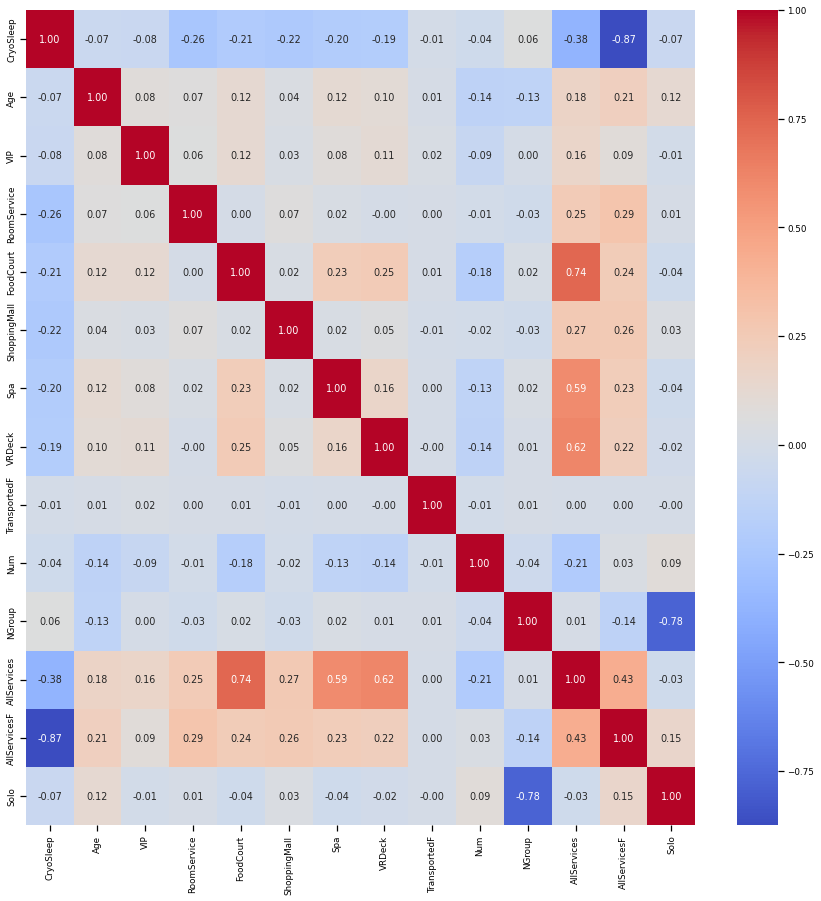

In [67]:
import matplotlib.pyplot as plt
# Heatmap (correlation)
sns.set_context('notebook', font_scale=0.8)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(ax=ax, data=df_full.corr(), annot=True, fmt= '.2f', cmap='coolwarm')

## ML

In [68]:
# calculate skewness scores for numerical features
skewness = X[num_cols].skew(axis=0, numeric_only = True).to_dict()

# define skewness threshold
skewness_threshold = 0.5

# create lists of columns that require normalizing 
skewed_cols = []
for i in skewness:
    if abs(skewness[i]) > skewness_threshold:
        skewed_cols.append(i)

# print results
for i in skewed_cols:
    print(f"Column {i} is skewed: score {round(skewness[i], 2)}")

Column RoomService is skewed: score 6.31
Column FoodCourt is skewed: score 7.17
Column ShoppingMall is skewed: score 12.38
Column Spa is skewed: score 7.67
Column VRDeck is skewed: score 7.89
Column Num is skewed: score 0.72
Column AllServices is skewed: score 4.48


In [69]:
# Split data into train and test sets

# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state=43)

In [70]:
# Create transformer for preprocessing numerical and categorical features
column_trans = ColumnTransformer([
    ('skewness', PowerTransformer(), skewed_cols),
    ('encoding', OneHotEncoder(drop = 'first', dtype = 'int', handle_unknown = 'ignore'), cat_cols)
], remainder = 'passthrough')

In [71]:
# Just cheking
X_train_norm = column_trans.fit_transform(X_train)
X_train_norm.shape

(6954, 31)

In [72]:
# KFold for Grid Search
skf = StratifiedKFold(n_splits = 4)

In [73]:
# define function that fits KMeans model and returns data + kmeans labels column
# if n_clusters = 0 - just return data
def kmeans(data, n_clusters, random_state = 42):
    if n_clusters <= 0:
        return data
    else:
        km = KMeans(n_clusters = n_clusters, random_state = random_state)
        km = km.fit(data)
        new_col = km.predict(data)
        new_col = new_col.reshape(len(new_col), 1)
        data = np.append(data, new_col, axis=1)
        return data

### Logistic Regresion Baseline

In [74]:
# Logistic Regression
estimator_lr = Pipeline([("preprocessing", column_trans),
                         ("scaling", MaxAbsScaler ()),
                         ("clasifier", LogisticRegression(class_weight = 'balanced', solver='liblinear'))])

params_lr = {
    'clasifier__penalty': ['l1', 'l2'],
    'clasifier__C': np.geomspace(0.1, 5, 10)
}

In [75]:
# do grid search
grid_lr = GridSearchCV(estimator_lr, params_lr, 
                       scoring = 'f1', 
                       cv = skf, 
                       n_jobs = -1, verbose = True)
grid_lr.fit(X_train, y_train.values.ravel())

Fitting 4 folds for each of 20 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('skewness',
                                                                         PowerTransformer(),
                                                                         ['RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck',
                                                                          'Num',
                                                                          'AllServices']),


In [76]:
grid_lr.best_score_, grid_lr.best_params_

(0.7533843247965264,
 {'clasifier__C': 0.23853323044733007, 'clasifier__penalty': 'l1'})

In [77]:
# function to plot confusion matrix
def vis_conf_matrix(conf_martix, model_name):
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    conf_martix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         conf_martix.flatten()/np.sum(conf_martix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    _, ax = plt.subplots(figsize = (6,6))
    ax = sns.heatmap(conf_martix, annot=labels, fmt = '', 
                     annot_kws = {"size": 20, "weight": "bold"}, cmap = 'Blues')  
    labels = ['False', 'True']
    ax.set_title('Confusion Matrix for {}'.format(model_name), fontsize = 15)
    ax.set_xticklabels(labels, fontsize = 10)
    ax.set_yticklabels(labels, fontsize = 10)
    ax.set_xlabel('Prediction', fontsize = 15)
    ax.set_ylabel('Ground Truth', fontsize = 15)
    
# referenc https://www.kaggle.com/code/dariasvasileva/success-of-a-movie-classification

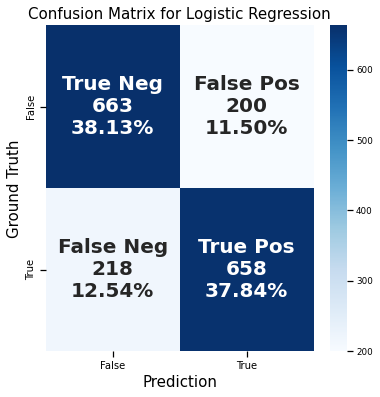

In [78]:
# predict target values
y_pred_lr = grid_lr.predict(X_valid)

# Plot confusion matrix
c_matrix_lr = confusion_matrix(y_valid, y_pred_lr)
vis_conf_matrix(c_matrix_lr, "Logistic Regression")

In [79]:
print(classification_report(y_valid, y_pred_lr))
print('Accuracy score: ', round(accuracy_score(y_valid, y_pred_lr), 2))
print('Precision score: ', round(precision_score(y_valid, y_pred_lr), 2))
print('Recall score: ', round(recall_score(y_valid, y_pred_lr), 2))
print('F1 Score: ', round(f1_score(y_valid, y_pred_lr), 2))

              precision    recall  f1-score   support

       False       0.75      0.77      0.76       863
        True       0.77      0.75      0.76       876

    accuracy                           0.76      1739
   macro avg       0.76      0.76      0.76      1739
weighted avg       0.76      0.76      0.76      1739

Accuracy score:  0.76
Precision score:  0.77
Recall score:  0.75
F1 Score:  0.76


In [80]:
scores = pd.DataFrame(data = {'model': ['logistic regression'],   
                              'f1': [f1_score(y_valid, y_pred_lr)], 
                              'accuracy': [accuracy_score(y_valid, y_pred_lr)],
                              'precision': [precision_score(y_valid, y_pred_lr)],
                              'recall': [recall_score(y_valid, y_pred_lr)]})

scores.loc[scores.model == 'logistic regression', 
           ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_lr.ravel()/np.sum(c_matrix_lr)*100, 
                                                 decimals=2)
scores

,model,f1,accuracy,precision,recall,tn,fp,fn,tp
0,logistic regression,0.758939,0.759632,0.7669,0.751142,38.13,11.5,12.54,37.84


### Logistic Regression and Demensionality Reduction
#### PCA

In [81]:
# Logistic Regression with PCA
estimator_pca_lr = Pipeline([('preprocessing', column_trans),
                             ('scaling', MinMaxScaler()),
                             ('feature_reduction', PCA(random_state = 43)),
                             ('clasifier', LogisticRegression(class_weight = 'balanced', solver='liblinear'))])

params_pca_lr = {
    'feature_reduction__n_components': [x for x in range(15, 23)],
    'clasifier__penalty': ['l2'],
    'clasifier__C': np.geomspace(0.1, 1, 5)
}

In [82]:
# do grid search
grid_pca_lr = GridSearchCV(estimator_pca_lr, params_pca_lr, 
                           scoring = 'f1', 
                           error_score='raise',
                           cv = skf, 
                           n_jobs = -1, verbose = True)
grid_pca_lr.fit(X_train, y_train.values.ravel())

Fitting 4 folds for each of 40 candidates, totalling 160 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             error_score='raise',
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('skewness',
                                                                         PowerTransformer(),
                                                                         ['RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck',
                                                                          'Num',
                                                         

In [83]:
grid_pca_lr.best_score_, grid_pca_lr.best_params_

(0.7530722369669087,
 {'clasifier__C': 0.1778279410038923,
  'clasifier__penalty': 'l2',
  'feature_reduction__n_components': 19})

In [84]:
# predict target values
y_pred_pca_lr = grid_pca_lr.predict(X_valid)

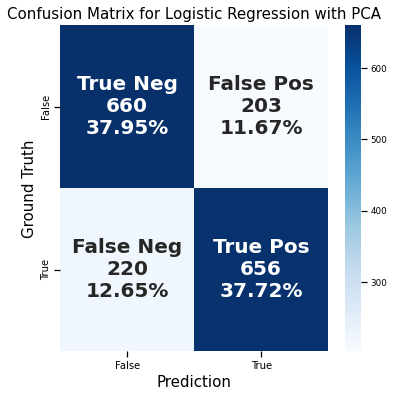

In [85]:
# Plot confusion matrix
c_matrix_pca_lr = confusion_matrix(y_valid, y_pred_pca_lr)
vis_conf_matrix(c_matrix_pca_lr, "Logistic Regression with PCA")

In [86]:
print(classification_report(y_valid, y_pred_pca_lr))
print('Accuracy score: ', round(accuracy_score(y_valid, y_pred_pca_lr), 2))
print('F1 Score: ', round(f1_score(y_valid, y_pred_pca_lr), 2))
print('Recall score: ', round(recall_score(y_valid, y_pred_lr), 2))
print('F1 Score: ', round(f1_score(y_valid, y_pred_lr), 2))

              precision    recall  f1-score   support

       False       0.75      0.76      0.76       863
        True       0.76      0.75      0.76       876

    accuracy                           0.76      1739
   macro avg       0.76      0.76      0.76      1739
weighted avg       0.76      0.76      0.76      1739

Accuracy score:  0.76
F1 Score:  0.76
Recall score:  0.75
F1 Score:  0.76


In [87]:
scores = scores.append({'model': 'pca logistic regression', 
                        'features': grid_pca_lr.best_estimator_.named_steps["clasifier"].n_features_in_, 
                        'f1': f1_score(y_valid, y_pred_pca_lr),
                        'accuracy': accuracy_score(y_valid, y_pred_pca_lr),
                        'precision': precision_score(y_valid, y_pred_lr),
                        'recall': recall_score(y_valid, y_pred_lr)}, 
                        ignore_index=True)

scores.loc[scores.model == 'pca logistic regression', 
           ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_pca_lr.ravel()/np.sum(c_matrix_pca_lr)*100, 
                                                 decimals=2)
scores

,model,f1,accuracy,precision,recall,tn,fp,fn,tp,features
0,logistic regression,0.758939,0.759632,0.7669,0.751142,38.13,11.50,12.54,37.84,NaN
1,pca logistic regression,0.756196,0.756757,0.7669,0.751142,37.95,11.67,12.65,37.72,19.0


#### KernelPCA

In [88]:
# Logistic Regression with KernelPCA
estimator_kpca_lr = Pipeline([("preprocessing", column_trans),
                             ("scaling", MinMaxScaler()),
                             ("feature_reduction", KernelPCA(random_state = 43, kernel = 'rbf')),
                             ("clasifier", LogisticRegression(class_weight = 'balanced', solver='liblinear'))])

params_kpca_lr = {
    'feature_reduction__n_components': [x for x in range(27, 28)],
    'clasifier__penalty': ['l2'],
    'clasifier__C': [50]
}

In [89]:
# do grid search
grid_kpca_lr = GridSearchCV(estimator_kpca_lr, params_kpca_lr, 
                       scoring = 'f1', 
                       cv = skf, 
                       n_jobs = -1, verbose = True)
grid_kpca_lr.fit(X_train, y_train.values.ravel())

Fitting 4 folds for each of 1 candidates, totalling 4 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('skewness',
                                                                         PowerTransformer(),
                                                                         ['RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck',
                                                                          'Num',
                                                                          'AllServices']),


In [90]:
grid_kpca_lr.best_score_, grid_kpca_lr.best_params_

(0.7529727197319277,
 {'clasifier__C': 50,
  'clasifier__penalty': 'l2',
  'feature_reduction__n_components': 27})

In [91]:
# predict target values
y_pred_kpca_lr = grid_kpca_lr.predict(X_valid)

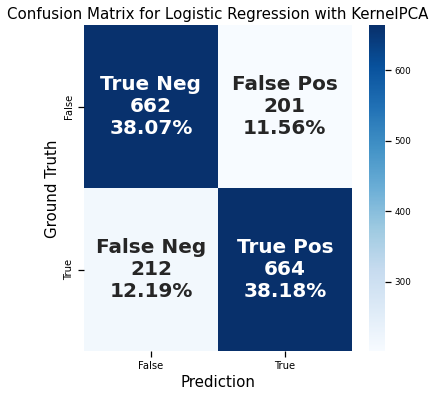

In [92]:
# Plot confusion matrix
c_matrix_kpca_lr = confusion_matrix(y_valid, y_pred_kpca_lr)
vis_conf_matrix(c_matrix_kpca_lr, "Logistic Regression with KernelPCA")

In [93]:
print(classification_report(y_valid, y_pred_kpca_lr))
print('Accuracy score: ', round(accuracy_score(y_valid, y_pred_kpca_lr), 2))
print('F1 Score: ', round(f1_score(y_valid, y_pred_kpca_lr), 2))
print('Recall score: ', round(recall_score(y_valid, y_pred_lr), 2))
print('F1 Score: ', round(f1_score(y_valid, y_pred_lr), 2))

              precision    recall  f1-score   support

       False       0.76      0.77      0.76       863
        True       0.77      0.76      0.76       876

    accuracy                           0.76      1739
   macro avg       0.76      0.76      0.76      1739
weighted avg       0.76      0.76      0.76      1739

Accuracy score:  0.76
F1 Score:  0.76
Recall score:  0.75
F1 Score:  0.76


In [94]:
scores = scores.append({'model': 'kernel pca logistic regression', 
                        'features': grid_kpca_lr.best_estimator_.named_steps["clasifier"].n_features_in_, 
                        'f1': f1_score(y_valid, y_pred_kpca_lr),
                        'accuracy': accuracy_score(y_valid, y_pred_kpca_lr),
                        'precision': precision_score(y_valid, y_pred_lr),
                        'recall': recall_score(y_valid, y_pred_lr)}, 
                        ignore_index=True)

scores.loc[scores.model == 'kernel pca logistic regression', 
           ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_kpca_lr.ravel()/np.sum(c_matrix_kpca_lr)*100, 
                                                 decimals=2)
scores

,model,f1,accuracy,precision,recall,tn,fp,fn,tp,features
0,logistic regression,0.758939,0.759632,0.7669,0.751142,38.13,11.50,12.54,37.84,NaN
1,pca logistic regression,0.756196,0.756757,0.7669,0.751142,37.95,11.67,12.65,37.72,19.0
2,kernel pca logistic regression,0.762780,0.762507,0.7669,0.751142,38.07,11.56,12.19,38.18,27.0


### Logistic Regression and Clustering
#### KMeans

In [95]:
# Logistic Regression with kmeans
estimator_km_lr = Pipeline([("preprocessing", column_trans),
                             ("scaling", MinMaxScaler()),
                             ("clustering", FunctionTransformer(kmeans)),
                             ("clasifier", LogisticRegression(class_weight = 'balanced', solver='liblinear'))])

params_km_lr = {
    'clustering__kw_args': [{'n_clusters': i} for i in range(2,4)],
    'clasifier__penalty': ['l2'],
    'clasifier__C': np.geomspace(0.01, 10, 5)
}

In [96]:
# do grid search
grid_km_lr = GridSearchCV(estimator_km_lr, params_km_lr, 
                       scoring = 'f1', 
                       cv = skf, 
                       n_jobs = -1, verbose = True)
grid_km_lr.fit(X_train, y_train.values.ravel())

Fitting 4 folds for each of 10 candidates, totalling 40 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('skewness',
                                                                         PowerTransformer(),
                                                                         ['RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck',
                                                                          'Num',
                                                                          'AllServices']),


In [97]:
grid_km_lr.best_score_, grid_km_lr.best_params_

(0.7510171269522499,
 {'clasifier__C': 0.05623413251903491,
  'clasifier__penalty': 'l2',
  'clustering__kw_args': {'n_clusters': 2}})

In [98]:
# predict target values
y_pred_km_lr = grid_km_lr.predict(X_valid)

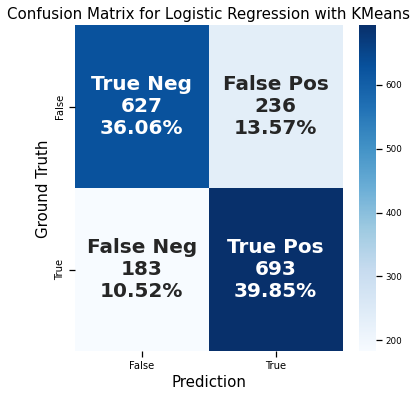

In [99]:
# Plot confusion matrix
c_matrix_km_lr = confusion_matrix(y_valid, y_pred_km_lr)
vis_conf_matrix(c_matrix_km_lr, "Logistic Regression with KMeans")

In [100]:
print(classification_report(y_valid, y_pred_km_lr))
print('Accuracy score: ', round(accuracy_score(y_valid, y_pred_km_lr), 2))
print('F1 Score: ', round(f1_score(y_valid, y_pred_km_lr), 2))
print('Recall score: ', round(recall_score(y_valid, y_pred_km_lr), 2))
print('F1 Score: ', round(f1_score(y_valid, y_pred_km_lr), 2))

              precision    recall  f1-score   support

       False       0.77      0.73      0.75       863
        True       0.75      0.79      0.77       876

    accuracy                           0.76      1739
   macro avg       0.76      0.76      0.76      1739
weighted avg       0.76      0.76      0.76      1739

Accuracy score:  0.76
F1 Score:  0.77
Recall score:  0.79
F1 Score:  0.77


In [101]:
scores = scores.append({'model': 'kmeans logistic regression', 
                        'features': grid_km_lr.best_estimator_.named_steps['clasifier'].n_features_in_, 
                        'f1': f1_score(y_valid, y_pred_km_lr),
                        'accuracy': accuracy_score(y_valid, y_pred_km_lr),
                        'precision': precision_score(y_valid, y_pred_km_lr),
                        'recall': recall_score(y_valid, y_pred_km_lr)}, 
                        ignore_index=True)

scores.loc[scores.model == 'kmeans logistic regression', 
           ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_km_lr.ravel()/np.sum(c_matrix_km_lr)*100, 
                                                 decimals=2)
scores

,model,f1,accuracy,precision,recall,tn,fp,fn,tp,features
0,logistic regression,0.758939,0.759632,0.766900,0.751142,38.13,11.50,12.54,37.84,NaN
1,pca logistic regression,0.756196,0.756757,0.766900,0.751142,37.95,11.67,12.65,37.72,19.0
2,kernel pca logistic regression,0.762780,0.762507,0.766900,0.751142,38.07,11.56,12.19,38.18,27.0
3,kmeans logistic regression,0.767867,0.759057,0.745963,0.791096,36.06,13.57,10.52,39.85,32.0


#### Agglomerative Clustering

In [102]:
# define function that fits clustering model and returns data + clustering labels column
def agg_cluster(data, n_clusters, linkage = 'ward'):
    if n_clusters <= 0:
        return data
    else:
        agg = AgglomerativeClustering(n_clusters = n_clusters, linkage = linkage)
        new_col = agg.fit_predict(data)
        new_col = new_col.reshape(len(new_col), 1)
        data = np.append(data, new_col, axis=1)
        return data

In [103]:
# Logistic Regression with kmeans
estimator_ag_lr = Pipeline([("preprocessing", column_trans),
                             ("scaling", MinMaxScaler()),
                             ("clustering", FunctionTransformer(agg_cluster)),
                             ("clasifier", LogisticRegression(class_weight = 'balanced', solver='liblinear'))])

params_ag_lr = {
    'clustering__kw_args': [{'n_clusters': i} for i in range(2,5)],
    'clasifier__penalty': ['l2'],
    'clasifier__C': np.geomspace(0.1, 10, 5)
}

In [104]:
# do grid search
grid_ag_lr = GridSearchCV(estimator_ag_lr, params_ag_lr, 
                       scoring = 'f1', 
                       cv = skf, 
                       n_jobs = -1, verbose = True)
grid_ag_lr.fit(X_train, y_train.values.ravel())

Fitting 4 folds for each of 15 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('skewness',
                                                                         PowerTransformer(),
                                                                         ['RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck',
                                                                          'Num',
                                                                          'AllServices']),


In [105]:
grid_ag_lr.best_score_, grid_ag_lr.best_params_

(0.7526813765830597,
 {'clasifier__C': 1.0,
  'clasifier__penalty': 'l2',
  'clustering__kw_args': {'n_clusters': 2}})

In [106]:
# predict target values
y_pred_ag_lr = grid_ag_lr.predict(X_valid)

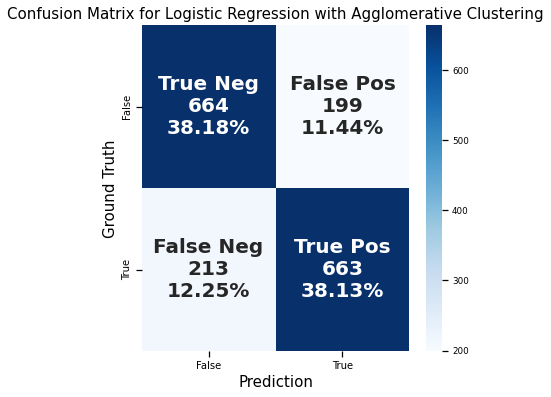

In [107]:
# Plot confusion matrix
c_matrix_ag_lr = confusion_matrix(y_valid, y_pred_ag_lr)
vis_conf_matrix(c_matrix_ag_lr, "Logistic Regression with Agglomerative Clustering")

In [108]:
print(classification_report(y_valid, y_pred_ag_lr))
print('Accuracy score: ', round(accuracy_score(y_valid, y_pred_ag_lr), 2))
print('F1 Score: ', round(f1_score(y_valid, y_pred_ag_lr), 2))
print('Recall score: ', round(recall_score(y_valid, y_pred_ag_lr), 2))
print('F1 Score: ', round(f1_score(y_valid, y_pred_ag_lr), 2))

              precision    recall  f1-score   support

       False       0.76      0.77      0.76       863
        True       0.77      0.76      0.76       876

    accuracy                           0.76      1739
   macro avg       0.76      0.76      0.76      1739
weighted avg       0.76      0.76      0.76      1739

Accuracy score:  0.76
F1 Score:  0.76
Recall score:  0.76
F1 Score:  0.76


In [109]:
scores = scores.append({'model': 'agg_clustering logistic regression', 
                        'features': grid_ag_lr.best_estimator_.named_steps['clasifier'].n_features_in_, 
                        'f1': f1_score(y_valid, y_pred_ag_lr),
                        'accuracy': accuracy_score(y_valid, y_pred_ag_lr),
                        'precision': precision_score(y_valid, y_pred_ag_lr),
                        'recall': recall_score(y_valid, y_pred_ag_lr)}, 
                        ignore_index=True)

scores.loc[scores.model == 'agg_clustering logistic regression', 
           ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_ag_lr.ravel()/np.sum(c_matrix_ag_lr)*100, 
                                                 decimals=2)
scores

,model,f1,accuracy,precision,recall,tn,fp,fn,tp,features
0,logistic regression,0.758939,0.759632,0.766900,0.751142,38.13,11.50,12.54,37.84,NaN
1,pca logistic regression,0.756196,0.756757,0.766900,0.751142,37.95,11.67,12.65,37.72,19.0
2,kernel pca logistic regression,0.762780,0.762507,0.766900,0.751142,38.07,11.56,12.19,38.18,27.0
3,kmeans logistic regression,0.767867,0.759057,0.745963,0.791096,36.06,13.57,10.52,39.85,32.0
4,agg_clustering logistic regression,0.762946,0.763082,0.769142,0.756849,38.18,11.44,12.25,38.13,32.0


### CatBoost baseline

In [110]:
# # It is needed for CatBosst model normal working
y_train_cat = y_train.astype(str)

In [111]:
# Cat
# I used here only the best parameters because it needs a too long time to show all that I have done. 
estimator_cat = Pipeline([("preprocessing", column_trans),
                          ("scaling", MaxAbsScaler ()),
                          ("clasifier", CatBoostClassifier(random_state=0, verbose=False))])

params_cat = {
              'clasifier__n_estimators': [2000], 
              'clasifier__max_depth': [5],
              'clasifier__learning_rate': [0.005],
              'clasifier__l2_leaf_reg': [0.01],
}

grid_cat = GridSearchCV(estimator_cat, params_cat, 
                       scoring = 'accuracy', 
                       cv=skf, 
                       n_jobs = -1, #verbose = 1
                        error_score= 'raise',
                        
                        )
grid_cat.fit(X_train, y_train_cat.values.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             error_score='raise',
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('skewness',
                                                                         PowerTransformer(),
                                                                         ['RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck',
                                                                          'Num',
                                                         

In [112]:
grid_cat.best_score_, grid_cat.best_params_

(0.8091728643169527,
 {'clasifier__l2_leaf_reg': 0.01,
  'clasifier__learning_rate': 0.005,
  'clasifier__max_depth': 5,
  'clasifier__n_estimators': 2000})

In [113]:
y_valid_cat = y_valid.astype(str)

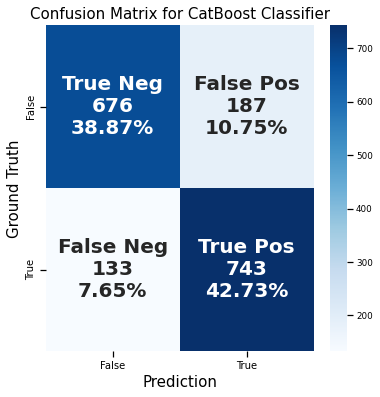

In [114]:
# predict target values
y_pred_cat = grid_cat.predict(X_valid)

# Plot confusion matrix
c_matrix_cat = confusion_matrix(y_valid_cat, y_pred_cat)
vis_conf_matrix(c_matrix_cat, "CatBoost Classifier")

In [115]:
print(classification_report(y_valid_cat, y_pred_cat))
print('Accuracy score: ', round(accuracy_score(y_valid_cat, y_pred_cat), 2))
print('Precision score: ', round(precision_score(y_valid_cat, y_pred_cat, pos_label = 'True'), 2))
print('Recall score: ', round(recall_score(y_valid_cat, y_pred_cat, pos_label = 'True'), 2))
print('F1 Score: ', round(f1_score(y_valid_cat, y_pred_cat, pos_label = 'True'), 2))

              precision    recall  f1-score   support

       False       0.84      0.78      0.81       863
        True       0.80      0.85      0.82       876

    accuracy                           0.82      1739
   macro avg       0.82      0.82      0.82      1739
weighted avg       0.82      0.82      0.82      1739

Accuracy score:  0.82
Precision score:  0.8
Recall score:  0.85
F1 Score:  0.82


In [116]:
scores = scores.append({'model': 'CatBoost', 
                        'f1': f1_score(y_valid_cat, y_pred_cat, pos_label = 'True'),
                        'accuracy': accuracy_score(y_valid_cat, y_pred_cat),
                        'precision': precision_score(y_valid_cat, y_pred_cat, pos_label = 'True'),
                        'recall': recall_score(y_valid_cat, y_pred_cat, pos_label = 'True')
                       }, 
                        ignore_index=True
                        )

scores.loc[scores.model == 'CatBoost', 
           ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_cat.ravel()/np.sum(c_matrix_cat)*100, 
                                                 decimals=2)
scores

,model,f1,accuracy,precision,recall,tn,fp,fn,tp,features
0,logistic regression,0.758939,0.759632,0.766900,0.751142,38.13,11.50,12.54,37.84,NaN
1,pca logistic regression,0.756196,0.756757,0.766900,0.751142,37.95,11.67,12.65,37.72,19.0
2,kernel pca logistic regression,0.762780,0.762507,0.766900,0.751142,38.07,11.56,12.19,38.18,27.0
3,kmeans logistic regression,0.767867,0.759057,0.745963,0.791096,36.06,13.57,10.52,39.85,32.0
4,agg_clustering logistic regression,0.762946,0.763082,0.769142,0.756849,38.18,11.44,12.25,38.13,32.0
5,CatBoost,0.822813,0.815986,0.798925,0.848174,38.87,10.75,7.65,42.73,NaN


### CatBoost and Demensionality Reduction
#### PCA

In [117]:
# Cat with PCA
estimator_pca_cat = Pipeline([('preprocessing', column_trans),
                             ('scaling', MaxAbsScaler ()),
                             ('feature_reduction', PCA(random_state = 44)),
                             ('clasifier', CatBoostClassifier(random_state=0, verbose=False))])

params_pca_cat = {
    'feature_reduction__n_components': [13],
#         x for x in range(16, 22)
              'clasifier__n_estimators': [2000], 
              'clasifier__max_depth': [5],
              'clasifier__learning_rate': [0.005],
              'clasifier__l2_leaf_reg': [0.01]
}

In [118]:
# do grid search
grid_pca_cat = GridSearchCV(estimator_pca_cat, params_pca_cat, 
                       scoring = 'accuracy', 
                       cv = skf, 
                       n_jobs = -1, verbose = True)
grid_pca_cat.fit(X_train, y_train_cat.values.ravel())

Fitting 4 folds for each of 1 candidates, totalling 4 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('skewness',
                                                                         PowerTransformer(),
                                                                         ['RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck',
                                                                          'Num',
                                                                          'AllServices']),


In [119]:
grid_pca_cat.best_score_, grid_pca_cat.best_params_

(0.7679035112040767,
 {'clasifier__l2_leaf_reg': 0.01,
  'clasifier__learning_rate': 0.005,
  'clasifier__max_depth': 5,
  'clasifier__n_estimators': 2000,
  'feature_reduction__n_components': 13})

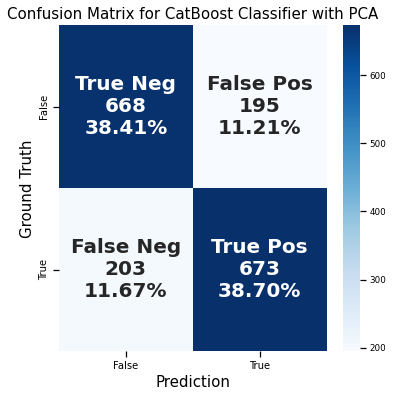

In [120]:
# predict target values
y_pred_pca_cat = grid_pca_cat.predict(X_valid)

# Plot confusion matrix
c_matrix_pca_cat = confusion_matrix(y_valid_cat, y_pred_pca_cat)
vis_conf_matrix(c_matrix_pca_cat, "CatBoost Classifier with PCA")

In [121]:
print(classification_report(y_valid_cat, y_pred_pca_cat))
print('Accuracy score: ', round(accuracy_score(y_valid_cat, y_pred_pca_cat), 2))
print('Precision score: ', round(precision_score(y_valid_cat, y_pred_pca_cat, pos_label = 'True'), 2))
print('Recall score: ', round(recall_score(y_valid_cat, y_pred_pca_cat, pos_label = 'True'), 2))
print('F1 Score: ', round(f1_score(y_valid_cat, y_pred_pca_cat, pos_label = 'True'), 2))

              precision    recall  f1-score   support

       False       0.77      0.77      0.77       863
        True       0.78      0.77      0.77       876

    accuracy                           0.77      1739
   macro avg       0.77      0.77      0.77      1739
weighted avg       0.77      0.77      0.77      1739

Accuracy score:  0.77
Precision score:  0.78
Recall score:  0.77
F1 Score:  0.77


In [122]:
scores = scores.append({'model': 'CatBoost with PCA', 
                        'f1': f1_score(y_valid_cat, y_pred_pca_cat, pos_label = 'True'),
                        'accuracy': accuracy_score(y_valid_cat, y_pred_pca_cat),
                        'precision': precision_score(y_valid_cat, y_pred_pca_cat, pos_label = 'True'),
                        'recall': recall_score(y_valid_cat, y_pred_pca_cat, pos_label = 'True'),
                        'features': grid_pca_cat.best_estimator_.named_steps['clasifier'].n_features_in_,
                       }, 
                        ignore_index=True
                        )

scores.loc[scores.model == 'CatBoost with PCA', 
           ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_pca_cat.ravel()/np.sum(c_matrix_pca_cat)*100, 
                                                 decimals=2)
scores

,model,f1,accuracy,precision,recall,tn,fp,fn,tp,features
0,logistic regression,0.758939,0.759632,0.766900,0.751142,38.13,11.50,12.54,37.84,NaN
1,pca logistic regression,0.756196,0.756757,0.766900,0.751142,37.95,11.67,12.65,37.72,19.0
2,kernel pca logistic regression,0.762780,0.762507,0.766900,0.751142,38.07,11.56,12.19,38.18,27.0
3,kmeans logistic regression,0.767867,0.759057,0.745963,0.791096,36.06,13.57,10.52,39.85,32.0
4,agg_clustering logistic regression,0.762946,0.763082,0.769142,0.756849,38.18,11.44,12.25,38.13,32.0
5,CatBoost,0.822813,0.815986,0.798925,0.848174,38.87,10.75,7.65,42.73,NaN
6,CatBoost with PCA,0.771789,0.771133,0.775346,0.768265,38.41,11.21,11.67,38.70,13.0


#### KernelPCA

In [123]:
# Cat with KernelPCA
estimator_kpca_cat = Pipeline([('preprocessing', column_trans),
                             ('scaling', MaxAbsScaler ()),
                             ('feature_reduction', KernelPCA(random_state = 44,  kernel = 'rbf')),
                             ('clasifier', CatBoostClassifier(random_state=0, verbose=False))])

params_kpca_cat = {
    'feature_reduction__n_components': [13],
#         x for x in range(16, 22)
              'clasifier__n_estimators': [2000], 
              'clasifier__max_depth': [5],
              'clasifier__learning_rate': [0.005],
              'clasifier__l2_leaf_reg': [0.01]
}

In [124]:
# do grid search
grid_kpca_cat = GridSearchCV(estimator_kpca_cat, params_kpca_cat, 
                       scoring = 'accuracy', 
                       cv = skf, 
                       n_jobs = -1, verbose = True)
grid_kpca_cat.fit(X_train, y_train_cat.values.ravel())

Fitting 4 folds for each of 1 candidates, totalling 4 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('skewness',
                                                                         PowerTransformer(),
                                                                         ['RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck',
                                                                          'Num',
                                                                          'AllServices']),


In [125]:
grid_kpca_cat.best_score_, grid_kpca_cat.best_params_

(0.7690537628929764,
 {'clasifier__l2_leaf_reg': 0.01,
  'clasifier__learning_rate': 0.005,
  'clasifier__max_depth': 5,
  'clasifier__n_estimators': 2000,
  'feature_reduction__n_components': 13})

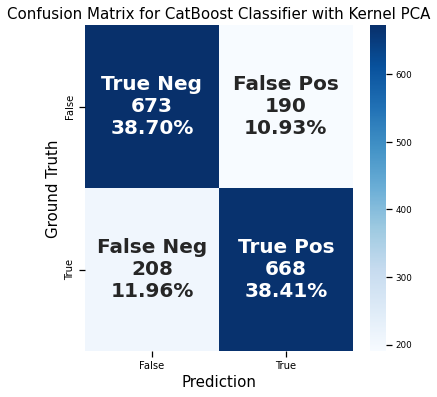

In [126]:
# predict target values
y_pred_kpca_cat = grid_kpca_cat.predict(X_valid)

# Plot confusion matrix
c_matrix_kpca_cat = confusion_matrix(y_valid_cat, y_pred_kpca_cat)
vis_conf_matrix(c_matrix_kpca_cat, "CatBoost Classifier with Kernel PCA")

In [127]:
print(classification_report(y_valid_cat, y_pred_kpca_cat))
print('Accuracy score: ', round(accuracy_score(y_valid_cat, y_pred_kpca_cat), 2))
print('Precision score: ', round(precision_score(y_valid_cat, y_pred_kpca_cat, pos_label = 'True'), 2))
print('Recall score: ', round(recall_score(y_valid_cat, y_pred_kpca_cat, pos_label = 'True'), 2))
print('F1 Score: ', round(f1_score(y_valid_cat, y_pred_kpca_cat, pos_label = 'True'), 2))

              precision    recall  f1-score   support

       False       0.76      0.78      0.77       863
        True       0.78      0.76      0.77       876

    accuracy                           0.77      1739
   macro avg       0.77      0.77      0.77      1739
weighted avg       0.77      0.77      0.77      1739

Accuracy score:  0.77
Precision score:  0.78
Recall score:  0.76
F1 Score:  0.77


In [128]:
scores = scores.append({'model': 'CatBoost with Kernel PCA', 
                        'f1': f1_score(y_valid_cat, y_pred_kpca_cat, pos_label = 'True'),
                        'accuracy': accuracy_score(y_valid_cat, y_pred_kpca_cat),
                        'precision': precision_score(y_valid_cat, y_pred_kpca_cat, pos_label = 'True'),
                        'recall': recall_score(y_valid_cat, y_pred_kpca_cat, pos_label = 'True'),
                        'features': grid_kpca_cat.best_estimator_.named_steps['clasifier'].n_features_in_,
                       }, 
                        ignore_index=True)

scores.loc[scores.model == 'CatBoost with kernel PCA', 
           ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_kpca_cat.ravel()/np.sum(c_matrix_kpca_cat)*100, 
                                                 decimals=2)
scores
# I don't know why there are not ['tn', 'fp', 'fn', 'tp'] in the Table

,model,f1,accuracy,precision,recall,tn,fp,fn,tp,features
0,logistic regression,0.758939,0.759632,0.766900,0.751142,38.13,11.50,12.54,37.84,NaN
1,pca logistic regression,0.756196,0.756757,0.766900,0.751142,37.95,11.67,12.65,37.72,19.0
2,kernel pca logistic regression,0.762780,0.762507,0.766900,0.751142,38.07,11.56,12.19,38.18,27.0
3,kmeans logistic regression,0.767867,0.759057,0.745963,0.791096,36.06,13.57,10.52,39.85,32.0
4,agg_clustering logistic regression,0.762946,0.763082,0.769142,0.756849,38.18,11.44,12.25,38.13,32.0
5,CatBoost,0.822813,0.815986,0.798925,0.848174,38.87,10.75,7.65,42.73,NaN
6,CatBoost with PCA,0.771789,0.771133,0.775346,0.768265,38.41,11.21,11.67,38.70,13.0
7,CatBoost with Kernel PCA,0.770473,0.771133,0.778555,0.762557,NaN,NaN,NaN,NaN,13.0


### Cat Boost and Clustering
#### KMeans

In [129]:
# Cat with KMeans
estimator_km_cat = Pipeline([('preprocessing', column_trans),
                             ('scaling', MaxAbsScaler ()),
                             ('clustering', FunctionTransformer(kmeans)),
                             ('clasifier', CatBoostClassifier(random_state=0, verbose=False))])

params_km_cat = {
    'clustering__kw_args': [{'n_clusters': i} for i in range(2, 3)],
                  'clasifier__n_estimators': [2000], 
              'clasifier__max_depth': [5],
              'clasifier__learning_rate': [0.005],
              'clasifier__l2_leaf_reg': [0.01]
}

In [130]:
# do grid search
grid_km_cat = GridSearchCV(estimator_km_cat, params_km_cat, 
                       scoring = 'accuracy', 
                       cv = skf, 
                       n_jobs = -1, verbose = True)
grid_km_cat.fit(X_train, y_train_cat.values.ravel())

Fitting 4 folds for each of 1 candidates, totalling 4 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('skewness',
                                                                         PowerTransformer(),
                                                                         ['RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck',
                                                                          'Num',
                                                                          'AllServices']),


In [131]:
grid_km_cat.best_score_, grid_km_cat.best_params_

(0.8071599652194859,
 {'clasifier__l2_leaf_reg': 0.01,
  'clasifier__learning_rate': 0.005,
  'clasifier__max_depth': 5,
  'clasifier__n_estimators': 2000,
  'clustering__kw_args': {'n_clusters': 2}})

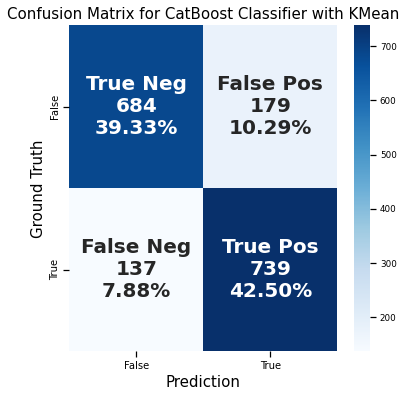

In [132]:
# predict target values
y_pred_km_cat = grid_km_cat.predict(X_valid)

# Plot confusion matrix
c_matrix_km_cat = confusion_matrix(y_valid_cat, y_pred_km_cat)
vis_conf_matrix(c_matrix_km_cat, "CatBoost Classifier with KMean")

In [133]:
print(classification_report(y_valid_cat, y_pred_km_cat))
print('Accuracy score: ', round(accuracy_score(y_valid_cat, y_pred_km_cat), 2))
print('Precision score: ', round(precision_score(y_valid_cat, y_pred_km_cat, pos_label = 'True'), 2))
print('Recall score: ', round(recall_score(y_valid_cat, y_pred_km_cat, pos_label = 'True'), 2))
print('F1 Score: ', round(f1_score(y_valid_cat, y_pred_km_cat, pos_label = 'True'), 2))

              precision    recall  f1-score   support

       False       0.83      0.79      0.81       863
        True       0.81      0.84      0.82       876

    accuracy                           0.82      1739
   macro avg       0.82      0.82      0.82      1739
weighted avg       0.82      0.82      0.82      1739

Accuracy score:  0.82
Precision score:  0.81
Recall score:  0.84
F1 Score:  0.82


In [134]:
scores = scores.append({'model': 'CatBoost with KMean', 
                        'f1': f1_score(y_valid_cat, y_pred_km_cat, pos_label = 'True'),
                        'accuracy': accuracy_score(y_valid_cat, y_pred_km_cat),
                        'precision': precision_score(y_valid_cat, y_pred_km_cat, pos_label = 'True'),
                        'recall': recall_score(y_valid_cat, y_pred_km_cat, pos_label = 'True'),
                        'features': grid_km_cat.best_estimator_.named_steps['clasifier'].n_features_in_,
                       }, 
                        ignore_index=True)

scores.loc[scores.model == 'CatBoost with KMean', 
           ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_km_cat.ravel()/np.sum(c_matrix_km_cat)*100, 
                                                 decimals=2)
scores

,model,f1,accuracy,precision,recall,tn,fp,fn,tp,features
0,logistic regression,0.758939,0.759632,0.766900,0.751142,38.13,11.50,12.54,37.84,NaN
1,pca logistic regression,0.756196,0.756757,0.766900,0.751142,37.95,11.67,12.65,37.72,19.0
2,kernel pca logistic regression,0.762780,0.762507,0.766900,0.751142,38.07,11.56,12.19,38.18,27.0
3,kmeans logistic regression,0.767867,0.759057,0.745963,0.791096,36.06,13.57,10.52,39.85,32.0
4,agg_clustering logistic regression,0.762946,0.763082,0.769142,0.756849,38.18,11.44,12.25,38.13,32.0
5,CatBoost,0.822813,0.815986,0.798925,0.848174,38.87,10.75,7.65,42.73,NaN
6,CatBoost with PCA,0.771789,0.771133,0.775346,0.768265,38.41,11.21,11.67,38.70,13.0
7,CatBoost with Kernel PCA,0.770473,0.771133,0.778555,0.762557,NaN,NaN,NaN,NaN,13.0
8,CatBoost with KMean,0.823857,0.818286,0.805011,0.843607,39.33,10.29,7.88,42.50,32.0


#### Agglomerative Clustering

In [135]:
# Cat with Agglomerative Clustering
estimator_agc_cat = Pipeline([('preprocessing', column_trans),
                             ('scaling', MaxAbsScaler ()),
                             ('clustering', FunctionTransformer(agg_cluster)),
                             ('clasifier', CatBoostClassifier(random_state=0, verbose=False))])

params_agc_cat = {
    'clustering__kw_args': [{'n_clusters': i} for i in range(5,6)],
                  'clasifier__n_estimators': [2000], 
              'clasifier__max_depth': [5],
              'clasifier__learning_rate': [0.005],
              'clasifier__l2_leaf_reg': [0.01],
}

In [136]:
# do grid search
grid_agc_cat = GridSearchCV(estimator_agc_cat, params_agc_cat, 
                       scoring = 'accuracy', 
                       cv = skf, 
                       n_jobs = -1, verbose = True)
grid_agc_cat.fit(X_train, y_train_cat.values.ravel())

Fitting 4 folds for each of 1 candidates, totalling 4 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('skewness',
                                                                         PowerTransformer(),
                                                                         ['RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck',
                                                                          'Num',
                                                                          'AllServices']),


In [137]:
grid_agc_cat.best_score_, grid_agc_cat.best_params_

(0.8067271112652206,
 {'clasifier__l2_leaf_reg': 0.01,
  'clasifier__learning_rate': 0.005,
  'clasifier__max_depth': 5,
  'clasifier__n_estimators': 2000,
  'clustering__kw_args': {'n_clusters': 5}})

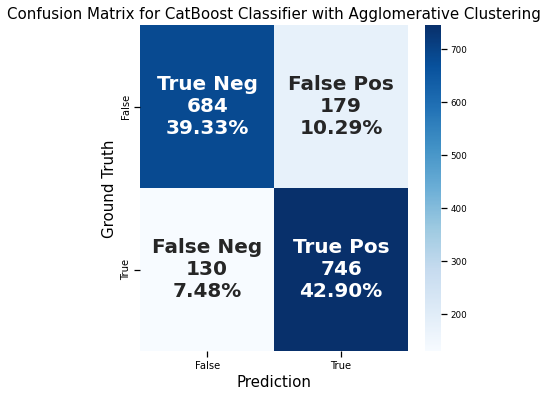

In [138]:
# predict target values
y_pred_agc_cat = grid_agc_cat.predict(X_valid)

# Plot confusion matrix
c_matrix_agc_cat = confusion_matrix(y_valid_cat, y_pred_agc_cat)
vis_conf_matrix(c_matrix_agc_cat, "CatBoost Classifier with Agglomerative Clustering")

In [139]:
print(classification_report(y_valid_cat, y_pred_agc_cat))
print('Accuracy score: ', round(accuracy_score(y_valid_cat, y_pred_agc_cat), 2))
print('Precision score: ', round(precision_score(y_valid_cat, y_pred_agc_cat, pos_label = 'True'), 2))
print('Recall score: ', round(recall_score(y_valid_cat, y_pred_agc_cat, pos_label = 'True'), 2))
print('F1 Score: ', round(f1_score(y_valid_cat, y_pred_agc_cat, pos_label = 'True'), 2))

              precision    recall  f1-score   support

       False       0.84      0.79      0.82       863
        True       0.81      0.85      0.83       876

    accuracy                           0.82      1739
   macro avg       0.82      0.82      0.82      1739
weighted avg       0.82      0.82      0.82      1739

Accuracy score:  0.82
Precision score:  0.81
Recall score:  0.85
F1 Score:  0.83


In [140]:
scores = scores.append({'model': 'CatBoost with AgC', 
                        'f1': f1_score(y_valid_cat, y_pred_agc_cat, pos_label = 'True'),
                        'accuracy': accuracy_score(y_valid_cat, y_pred_agc_cat),
                        'precision': precision_score(y_valid_cat, y_pred_agc_cat, pos_label = 'True'),
                        'recall': recall_score(y_valid_cat, y_pred_agc_cat, pos_label = 'True'),
                        'features': grid_agc_cat.best_estimator_.named_steps['clasifier'].n_features_in_,
                       }, 
                        ignore_index=True)

scores.loc[scores.model == 'CatBoost with AgC', 
           ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_agc_cat.ravel()/np.sum(c_matrix_agc_cat)*100, 
                                                 decimals=2)
scores

,model,f1,accuracy,precision,recall,tn,fp,fn,tp,features
0,logistic regression,0.758939,0.759632,0.766900,0.751142,38.13,11.50,12.54,37.84,NaN
1,pca logistic regression,0.756196,0.756757,0.766900,0.751142,37.95,11.67,12.65,37.72,19.0
2,kernel pca logistic regression,0.762780,0.762507,0.766900,0.751142,38.07,11.56,12.19,38.18,27.0
3,kmeans logistic regression,0.767867,0.759057,0.745963,0.791096,36.06,13.57,10.52,39.85,32.0
4,agg_clustering logistic regression,0.762946,0.763082,0.769142,0.756849,38.18,11.44,12.25,38.13,32.0
5,CatBoost,0.822813,0.815986,0.798925,0.848174,38.87,10.75,7.65,42.73,NaN
6,CatBoost with PCA,0.771789,0.771133,0.775346,0.768265,38.41,11.21,11.67,38.70,13.0
7,CatBoost with Kernel PCA,0.770473,0.771133,0.778555,0.762557,NaN,NaN,NaN,NaN,13.0
8,CatBoost with KMean,0.823857,0.818286,0.805011,0.843607,39.33,10.29,7.88,42.50,32.0
9,CatBoost with AgC,0.828429,0.822312,0.806486,0.851598,39.33,10.29,7.48,42.90,32.0


## Voting Classifiers

In [141]:
# Save best classifiers
# best_lr = grid_lr.best_estimator_
# best_ag_lr = grid_ag_lr.best_estimator_
# best_km_lr = grid_km_lr.best_estimator_
# best_kpca_lr = grid_kpca_lr.best_estimator_
# best_pca_lr = grid_pca_lr.best_estimator_
best_cat = grid_cat.best_estimator_
best_agc_cat = grid_agc_cat.best_estimator_
best_km_cat = grid_km_cat.best_estimator_
# best_kpca_cat = grid_kpca_cat.best_estimator_
# best_pca_cat = grid_pca_cat.best_estimator_


# set Voting Classifiers with 'hard' and 'soft' voting
# vc_hard_lr = VotingClassifier(estimators = [('lr', best_lr), ('lr_agc', best_ag_lr), ('lr_km', grid_km_lr), ('lr_kpca', grid_kpca_lr), ('lr_pca', grid_pca_lr)], voting = 'hard') 
# vc_soft_lr = VotingClassifier(estimators = [('lr', best_lr), ('lr_agc', best_ag_lr), ('lr_km', grid_km_lr), ('lr_kpca', grid_kpca_lr), ('lr_pca', grid_pca_lr)], voting = 'soft') 
vc_hard_cat = VotingClassifier(estimators = [('cat', best_cat), ('cat_agc', best_agc_cat), ('cat_km', grid_km_cat)], voting = 'hard') 
vc_soft_cat = VotingClassifier(estimators = [('cat', best_cat), ('cat_agc', best_agc_cat), ('cat_km', grid_km_cat)], voting = 'soft') 

# vc_hard_lr = vc_hard_lr.fit(X_train, y_train.values.ravel())
# vc_soft_lr = vc_soft_lr.fit(X_train, y_train.values.ravel())

vc_hard_cat = vc_hard_cat.fit(X_train, y_train.values.ravel())
vc_soft_cat = vc_soft_cat.fit(X_train, y_train.values.ravel())

# y_pred_vc_hard_lr = vc_hard_lr.predict(X_valid)
# y_pred_vc_soft_lr = vc_soft_lr.predict(X_valid)

y_pred_vc_hard_cat = vc_hard_cat.predict(X_valid)
y_pred_vc_soft_cat = vc_soft_cat.predict(X_valid)

# I prepared all for lr and cat voting, but lr model did provide not good results, and I did not perform this code

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits


In [142]:
# # Plot confusion matrix
# c_matrix_vc_hard_lr = confusion_matrix(y_valid, y_pred_vc_hard_lr)
# vis_conf_matrix(c_matrix_vc_hard_lr, "Voting Classifier (hard_lr)")

In [143]:
# # Plot confusion matrix
# c_matrix_vc_soft_lr = confusion_matrix(y_valid, y_pred_vc_soft_lr)
# vis_conf_matrix(c_matrix_vc_soft_lr, "Voting Classifier (soft_lr)")

In [144]:
# # add scores to the dataframe
# scores = scores.append({'model': 'voting hard_lr', 
#                         'f1': f1_score(y_valid, y_pred_vc_hard_lr),
#                         'accuracy': accuracy_score(y_valid, y_pred_vc_hard_lr),
#                         'precision': precision_score(y_valid, y_pred_vc_hard_lr),
#                         'recall': recall_score(y_valid, y_pred_vc_hard_lr)},
#                         ignore_index=True)

# scores = scores.append({'model': 'voting soft_lr',  
#                         'f1': f1_score(y_valid, y_pred_vc_soft_lr),
#                         'accuracy': accuracy_score(y_valid, y_pred_vc_soft_lr),
#                         'precision': precision_score(y_valid, y_pred_vc_soft_lr),
#                         'recall': recall_score(y_valid, y_pred_vc_soft_lr)},
#                         ignore_index=True)

# scores.loc[scores.model == 'voting hard_lr', 
#            ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_vc_hard_lr.ravel()/np.sum(c_matrix_vc_hard_lr)*100, 
#                                                  decimals=2)

# scores.loc[scores.model == 'voting soft_lr', 
#            ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_vc_soft_lr.ravel()/np.sum(c_matrix_vc_soft_lr)*100, 
#                                                  decimals=2)

# scores

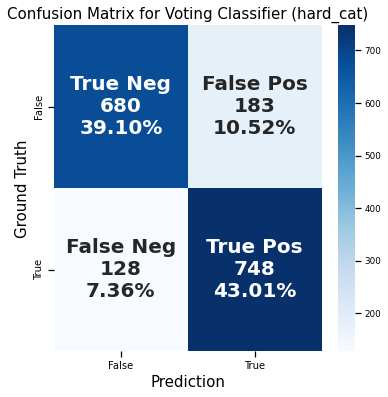

In [145]:
# Plot confusion matrix
c_matrix_vc_hard_cat = confusion_matrix(y_valid, y_pred_vc_hard_cat)
vis_conf_matrix(c_matrix_vc_hard_cat, "Voting Classifier (hard_cat)")

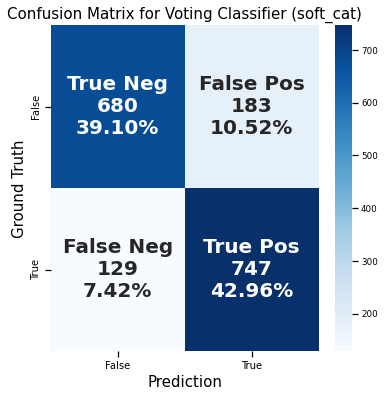

In [146]:
# Plot confusion matrix
c_matrix_vc_soft_cat = confusion_matrix(y_valid, y_pred_vc_soft_cat)
vis_conf_matrix(c_matrix_vc_soft_cat, "Voting Classifier (soft_cat)")

In [147]:
# y_pred_vc_hard_cat = y_pred_vc_hard_cat.astype(str)
# y_pred_vc_soft_cat = y_pred_vc_soft_cat.astype(str)

In [148]:
# y_valid = y_valid.astype(str

In [149]:
# add scores to the dataframe
scores = scores.append({'model': 'voting hard_cat', 
                        'f1': f1_score(y_valid, y_pred_vc_hard_cat, pos_label= True),
                        'accuracy': accuracy_score(y_valid, y_pred_vc_hard_cat),
                        'precision': precision_score(y_valid, y_pred_vc_hard_cat, pos_label= True),
                        'recall': recall_score(y_valid, y_pred_vc_hard_cat, pos_label= True)},
                        ignore_index=True)

scores = scores.append({'model': 'voting soft_cat',  
                        'f1': f1_score(y_valid, y_pred_vc_soft_cat, pos_label= True),
                        'accuracy': accuracy_score(y_valid, y_pred_vc_soft_cat),
                        'precision': precision_score(y_valid, y_pred_vc_soft_cat, pos_label= True),
                        'recall': recall_score(y_valid, y_pred_vc_soft_cat, pos_label= True)},
                        ignore_index=True)

scores.loc[scores.model == 'voting hard_cat', 
           ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_vc_hard_cat.ravel()/np.sum(c_matrix_vc_hard_cat)*100, 
                                                 decimals=2)

scores.loc[scores.model == 'voting soft_cat', 
           ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_vc_soft_cat.ravel()/np.sum(c_matrix_vc_soft_cat)*100, 
                                                 decimals=2)

scores

,model,f1,accuracy,precision,recall,tn,fp,fn,tp,features
0,logistic regression,0.758939,0.759632,0.766900,0.751142,38.13,11.50,12.54,37.84,NaN
1,pca logistic regression,0.756196,0.756757,0.766900,0.751142,37.95,11.67,12.65,37.72,19.0
2,kernel pca logistic regression,0.762780,0.762507,0.766900,0.751142,38.07,11.56,12.19,38.18,27.0
3,kmeans logistic regression,0.767867,0.759057,0.745963,0.791096,36.06,13.57,10.52,39.85,32.0
4,agg_clustering logistic regression,0.762946,0.763082,0.769142,0.756849,38.18,11.44,12.25,38.13,32.0
5,CatBoost,0.822813,0.815986,0.798925,0.848174,38.87,10.75,7.65,42.73,NaN
6,CatBoost with PCA,0.771789,0.771133,0.775346,0.768265,38.41,11.21,11.67,38.70,13.0
7,CatBoost with Kernel PCA,0.770473,0.771133,0.778555,0.762557,NaN,NaN,NaN,NaN,13.0
8,CatBoost with KMean,0.823857,0.818286,0.805011,0.843607,39.33,10.29,7.88,42.50,32.0
9,CatBoost with AgC,0.828429,0.822312,0.806486,0.851598,39.33,10.29,7.48,42.90,32.0


# Conclusions
## Key findings
* Addition of KMean or AgglomerativeClustering improved f1 of both Logistic Regression and CatBoost models. <br>
* Addition of Dimensionality Reduction methods (both PCA and KernelPCA) reduced all scores of both models
* Hard and Soft Voting for Cat Boost model with two best options (KMean and AgglomerativeClustering) slighly improve all scores.

## Next steps
I found that the addition of KMean or AgglomerativeClustering to Cat Boost models might be beneficial (in the context of the Titanic Spaceship dataset). I plan to compare performances of other classification models such as Support Vector Machines and Random Forest with and without KMean\AgglomerativeClustering and incorporate this technique into my Kaggle Titanic Spaceship competition notebook.

<p style="text-align: center; font-weight: 700;"> 
Thank you for reading!<br />
Since I am only at the beginning of my Data Science studying,<br /> 
any kind of feedback (positive or negative) is greatly appreciated.

</p>